# Trining and Prediction with Keras in AI Platform

<img src="https://storage.googleapis.com/cloud-samples-data/ml-engine/census/keras-tensorflow-cmle.png" alt="Keras, TensorFlow, and AI Platform logos" width="300px">

This notebook collection is inspired by the tutorial [Getting started: Training and prediction with Keras](https://cloud.google.com/ml-engine/docs/tensorflow/getting-started-keras)

## [Recommended project structure](https://cloud.google.com/ml-engine/docs/tensorflow/packaging-trainer#to_include_additional_pypi_dependencies)

To train models with AI Platform, you must upload your code and any dependencies into a Cloud Storage bucket that your Google Cloud Platform project can access.

You can structure your training application in any way you like. However, the following structure is commonly used in AI Platform samples, and having your project's organization be similar to the samples can make it easier for you to follow the samples.

- Use a main project directory, containing your `setup.py` file.

    `setup.py` contains the package's standard dependencies.

- Use a subdirectory named `trainer` to store your main application module.

- Name your main application module `task.py`.

- Create whatever other subdirectories in your main project directory that you need to implement your application.

- Create an `__init__.py` file in every subdirectory. These files are used by Setuptools to identify directories with code to package, and may be empty.

In the AI Platform samples, the `trainer` directory usually contains the following source files:

- `task.py` contains the application logic that manages the training job.

- `model.py` contains the TensorFlow graph code—the logic of the model.

- `util.py` if present, contains code to run the training application.

## 1. Using Keras with tf.data from numpy arrays on the memory
### Training application structure

The training code is located in the `./AI_Platform/tf-keras/numpy` directory

### `util.py`

In [ ]:
from tensorflow import keras
import tensorflow as tf
from keras.utils import np_utils
import numpy as np

def load_data():
    """Loads data into preprocessed (train_x, train_y, eval_x, eval_y) dataframes.
    
    Returns:
        A tuple (train_x, train_y, eval_x, eval_y), where train_x and eval_x are
        numpy arrays with features for training and train_y and eval_y are
        numpy arrays with the corresponding labels.
    """
    # Load image data from MNIST.
    (train_x, train_y),(eval_x, eval_y) = keras.datasets.mnist.load_data()

    # We convert the input data to (60000, 28, 28, 1), float32 and normalize our data values to the range [0, 1].
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2], 1)
    eval_x = eval_x.reshape(eval_x.shape[0], eval_x.shape[1], eval_x.shape[2], 1)

    train_x = train_x.astype('float32')
    eval_x = eval_x.astype('float32')
    train_x /= 255
    eval_x /= 255

    # Preprocess class labels 
    train_y = train_y.astype(np.int32)
    eval_y = eval_y.astype(np.int32)

    train_y = np_utils.to_categorical(train_y, 10)
    eval_y = np_utils.to_categorical(eval_y, 10)

    return train_x, train_y, eval_x, eval_y

### `model.py`

In [ ]:
"""Defines a Keras model and input function for training."""

import tensorflow as tf

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten # Keras core layes
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D # Keras CNN layers


def input_fn(features, labels, shuffle, num_epochs, batch_size):
    """Generates an input function to be used for model training.

    Args:
      features: numpy array of features used for training or inference
      labels: numpy array of labels for each example
      shuffle: boolean for whether to shuffle the data or not (set True for
        training, False for evaluation)
      num_epochs: number of epochs to provide the data for
      batch_size: batch size for training

    Returns:
      A tf.data.Dataset that can provide data to the Keras model for training or
        evaluation
    """
    if labels is None:
        inputs = features
    else:
        inputs = (features, labels)
    dataset = tf.data.Dataset.from_tensor_slices(inputs)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(features))

    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(batch_size)
    return dataset

def create_keras_model(inputShape, learning_rate):
    # Model input
    inputs = Input(shape=inputShape)
   
    # Convolutional layers    
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
  
    # Fully connected Dense layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
  
    outputs = Dense(10, activation='softmax')(x)
  
    model = Model(inputs=inputs, outputs=outputs, name='myModel')
  
    # Custom Optimizer:
    # https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer
    optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate)

    # Compile Keras model
    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer, metrics=['accuracy'])
      
    return model  

### `task.py`

In [ ]:
"""Trains a Keras model to predict handwritten numbers from MNIST data."""

import argparse
import os

from . import model
from . import util

import tensorflow as tf


def get_args():
    """Argument parser.

    Returns:
      Dictionary of arguments.
    """
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--job-dir',
        type=str,
        required=True,
        help='local or GCS location for writing checkpoints and exporting models')
    parser.add_argument(
        '--num-epochs',
        type=int,
        default=20,
        help='number of times to go through the data, default=20')
    parser.add_argument(
        '--batch-size',
        default=128,
        type=int,
        help='number of records to read during each training step, default=128')
    parser.add_argument(
        '--learning-rate',
        default=.01,
        type=float,
        help='learning rate for gradient descent, default=.01')
    parser.add_argument(
        '--verbosity',
        choices=['DEBUG', 'ERROR', 'FATAL', 'INFO', 'WARN'],
        default='INFO')
    args, _ = parser.parse_known_args()
    return args


def train_and_evaluate(args):
    """Trains and evaluates the Keras model.

    Uses the Keras model defined in model.py and trains on data loaded and
    preprocessed in util.py. Saves the trained model in TensorFlow SavedModel
    format to the path defined in part by the --job-dir argument.

    Args:
      args: dictionary of arguments - see get_args() for details
    """

    train_x, train_y, eval_x, eval_y = util.load_data()

    # dimensions
    num_train_examples = train_x.shape[0]
    inputShape = train_x.shape[1:]
    num_eval_examples = eval_x.shape[0]

    # Create the Keras Model
    keras_model = model.create_keras_model(
        inputShape = inputShape, learning_rate=args.learning_rate)

    # Pass a numpy array 
    training_dataset = model.input_fn(
        features=train_x,
        labels=train_y,
        shuffle=True,
        num_epochs=args.num_epochs,
        batch_size=args.batch_size)

    # Pass a numpy array 
    validation_dataset = model.input_fn(
        features=eval_x,
        labels=eval_y,
        shuffle=False,
        num_epochs=args.num_epochs,
        batch_size=num_eval_examples)

    # Setup Learning Rate decay.
    lr_decay_cb = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: args.learning_rate + 0.02 * (0.5 ** (1 + epoch)),
        verbose=True)

     # Setup TensorBoard callback.
    tensorboard_cb = tf.keras.callbacks.TensorBoard(
        os.path.join(args.job_dir, 'keras_tensorboard'),
        histogram_freq=1)

    # Train model
    keras_model.fit(
        training_dataset,
        steps_per_epoch=int(num_train_examples / args.batch_size),
        epochs=args.num_epochs,
        validation_data=validation_dataset,
        validation_steps=1,
        verbose=1,
        callbacks=[lr_decay_cb, tensorboard_cb])

    export_path = tf.contrib.saved_model.save_keras_model(
        keras_model, os.path.join(args.job_dir, 'keras_export'))
    export_path = export_path.decode('utf-8')
    print('Model exported to: ', export_path)


if __name__ == '__main__':
    args = get_args()
    tf.logging.set_verbosity(args.verbosity)
    train_and_evaluate(args)

## 3. Using Keras with tf.data from TFRecord files on Google Cloud Store 

**Write a TFRecord file**

Creating your dataset is pretty straightforward. All you need to do is to define your dataset using something like this:

In [18]:
import tensorflow as tf

# Helperfunctions to make your feature definition more readable
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(array):
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def writeTFRecord(filename, image, label):
    """
    filename : string
        TFRecord file name. 
    image : float
         Input numpy array.
    image : int
         Output numpy array.
    """
    
    # create filewriter
    options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)
    writer = tf.python_io.TFRecordWriter(filename, options=options)
    
    for i in range(label.shape[0]):
        
        # Define the features of your tfrecord
        #feature = {'image':  _bytes_feature(tf.compat.as_bytes(image[i].tostring())),
        #           'label':  _int64_feature(int(label[i]))}
        
        feature = {'image':  _float_feature(image[i]),
                   'label':  _int64_feature(int(label[i]))}
        
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        
        # Serialize to string and write to file
        writer.write(example.SerializeToString())
        
    writer.close()

In [31]:
from tensorflow import keras

(x_train, y_train),(x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


**Data should have 1D**

In [ ]:
nData_train = x_train.shape[0]
nData_test = x_test.shape[0]
nDimIn = x_train.shape[1]*x_train.shape[2]
input_shape = (x_train.shape[1], x_train.shape[2])


x_train_vec = x_train.reshape([nData_train,-1])
x_test_vec = x_test.reshape([nData_test,-1])

print(x_train_vec.shape, x_test_vec.shape, y_train.shape, y_test.shape)

**Save `tfrecords`**

In [ ]:
path_train_tfrecords = './data/mnist_train.tfrecords'
path_test_tfrecords = './data/mnist_test.tfrecords'

writeTFRecord(path_train_tfrecords, x_train_vec, y_train)
writeTFRecord(path_test_tfrecords, x_test_vec, y_test)

**Uploading objects to Cloud Storage bucket**

In [ ]:
from google.cloud import storage

def upload_blob(bucket_name, source_file_name, destination_blob_name, privatekey_path):
    """Uploads a file to the bucket."""
    storage_client = storage.Client.from_service_account_json(privatekey_path)
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print('File {} uploaded to {}.'.format(
        source_file_name,
        destination_blob_name))

In [ ]:
bucket_name = 'skydipper_materials'
privatekey_path =  "/Users/ikersanchez/Vizzuality/Keys/Skydipper/skydipper-562ee3e31bb2.json" #"/Users/keys/privatekey.json"

source_file_name = './data/mnist_train.tfrecords'
destination_blob_name = 'mist_tfrecords/mnist_train.tfrecords'
upload_blob(bucket_name, source_file_name, destination_blob_name, privatekey_path)

source_file_name = './data/mnist_test.tfrecords'
destination_blob_name = 'mist_tfrecords/mnist_test.tfrecords'
upload_blob(bucket_name, source_file_name, destination_blob_name, privatekey_path)

**[Reading a single record from TFRecord files](https://www.tensorflow.org/tutorials/load_data/tf_records#reading_a_tfrecord_file_2)**

The following example imports the data as is, as a tf.Example message. This can be useful to verify that a the file contains the data that we expect. This can also be useful if the input data is stored as TFRecords but you would prefer to input NumPy data (or some other input data type), for example [here](https://www.tensorflow.org/guide/datasets#consuming_numpy_arrays), since this example allows us to read the values themselves.

In [3]:
bucket_name = 'skydipper_materials'
fullpath_train = 'gs://'+bucket_name+'/'+'mist_tfrecords/mnist_train.tfrecords'
fullpath_test = 'gs://'+bucket_name+'/'+'mist_tfrecords/mnist_test.tfrecords'

In [4]:
options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)
record_iterator = tf.python_io.tf_record_iterator(path=fullpath_test, options=options)

for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    print(example)
    
    # Exit after 1 iteration as this is purely demonstrative.
    break

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
features {
  feature {
    key: "image"
    value {
      float_list {
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        

**[Recover the images from the TFRecord file](https://www.tensorflow.org/tutorials/load_data/tf_records#read_the_tfrecord_file)**

We now have the file `images.tfrecords`. We can now iterate over the records in the file to read back what we wrote. Since, for our use case we will just reproduce the image, the only feature we need is the image string. We can extract that using the getters described above, namely `example.features.feature['image'].bytes_list.value[0]`. We also use the labels to determine the number of the image.

In [32]:
def parse_function(proto):
    # define your tfrecord again. Remember that you saved your image as a string.
    #features = {'image': tf.FixedLenFeature([], tf.string),
    #            'label': tf.FixedLenFeature([], tf.int64)}
    
    features = {'image': tf.FixedLenFeature([], tf.float32),
                'label': tf.FixedLenFeature([], tf.int64)}
    
    # Load one example
    parsed_features = tf.parse_single_example(proto, features)
    
    # Turn your saved image string into an array
    #image = tf.decode_raw(parsed_features['image'], tf.float32)
    image = parsed_features['image']
    
    # Normalize
    image = tf.divide(image, 255.0)
    
    # Bring your picture back in shape
    #image = tf.reshape(image, [input_shape[0], input_shape[1], 1])
    
    # Create a one hot array for your labels
    label = tf.one_hot(parsed_features['label'], 10)
    
    return image, label

In [33]:
# This works with arrays as well
dataset = tf.data.TFRecordDataset(fullpath_train, compression_type='GZIP')
    
# Maps the preprocessing function. You can set the number of parallel loaders here
dataset = dataset.map(parse_function, num_parallel_calls=8)
    
dataset

<DatasetV1Adapter shapes: ((28, 28, 1), (10,)), types: (tf.float32, tf.float32)>

In [81]:
image_dataset = tf.data.TFRecordDataset(fullpath_train, compression_type='GZIP')


def parse_function(proto):
    # define your tfrecord again. Remember that you saved your image as a string.  
    features = {'image': tf.FixedLenFeature([28, 28, 1], tf.float32),
                'label': tf.FixedLenFeature([], tf.int64)}
    # Parse the input tf.Example proto using the dictionary above.
    parsed_features = tf.parse_single_example(proto, features)

    # Normalize image
    parsed_features['image'] = tf.divide(parsed_features['image'], 255.0)
    
    # Create a one hot array for your labels
    parsed_features['label'] = tf.one_hot(parsed_features['label'], 10)
    
    return parsed_features#image, label

dataset = image_dataset.map(parse_function)
dataset

<DatasetV1Adapter shapes: {image: (28, 28, 1), label: (10,)}, types: {image: tf.float32, label: tf.float32}>

Recover the images from the TFRecord file:

In [84]:
n = 0
for image_features in dataset:
    n += 1

In [87]:
image_dataset = tf.data.TFRecordDataset(fullpath_train, compression_type='GZIP')

In [92]:
options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)
n = sum(1 for _ in tf.python_io.tf_record_iterator(fullpath_test, options=options))

In [93]:
n

10000

Label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Image:


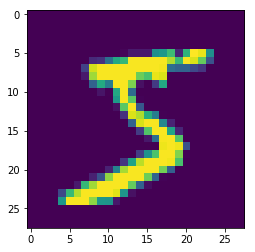

In [83]:
import matplotlib.pyplot as plt

for image_features in dataset:
    image = image_features['image'].numpy()
    label = image_features['label'].numpy()
    
    break
    
print('Label:', label)
print('Image:')
plt.imshow(image[:,:,0])

In [80]:
image.max()

1.0

### Training application structure

The training code is located in the `./AI_Platform/tf-keras/TFRecords` directory

### `util.py`

In [ ]:
import tensorflow as tf

def parse_function(proto):
    # define your tfrecord again. Remember that you saved your image as a string.  
    features = {'image': tf.FixedLenFeature([28, 28, 1], tf.float32),
                'label': tf.FixedLenFeature([], tf.int64)}
    
    # Load one example
    parsed_features = tf.parse_single_example(proto, features)
    
    # Turn your saved image string into an array
    image = parsed_features['image']
    
    # Normalize
    image = tf.divide(image, 255.0)
    
    # Create a one hot array for your labels
    label = tf.one_hot(parsed_features['label'], 10)
    
    return image, label

def create_dataset(filepath, shuffle_size, num_epochs, batch_size):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath, compression_type='GZIP')
    
    # Maps the preprocessing function. You can set the number of parallel loaders here
    dataset = dataset.map(parse_function, num_parallel_calls=8)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Set the number of datapoints you want to load and shuffle 
    dataset = dataset.shuffle(shuffle_size)
    
    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    dataset = dataset.repeat(num_epochs)
    
    # Set the batchsize
    dataset = dataset.batch(batch_size)
    
    # Create an iterator
    iterator = dataset.make_one_shot_iterator()
    
    return iterator

### `model.py`

In [ ]:
"""Defines a Keras model for training."""

import tensorflow as tf

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten # Keras core layes
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D # Keras CNN layers

def create_keras_model(inputShape, learning_rate):
    # Model input
    inputs = Input(shape=inputShape)
   
    # Convolutional layers    
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
  
    # Fully connected Dense layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
  
    outputs = Dense(10, activation='softmax')(x)
  
    model = Model(inputs=inputs, outputs=outputs, name='myModel')
  
    # Custom Optimizer:
    # https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer
    optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate)

    # Compile Keras model
    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer, metrics=['accuracy'])
      
    return model  

### `task.py`

In [ ]:
"""Trains a Keras model to predict handwritten numbers from MNIST data."""

import argparse
import os

from . import model
from . import util

import tensorflow as tf


def get_args():
    """Argument parser.

    Returns:
      Dictionary of arguments.
    """
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--job-dir',
        type=str,
        required=True,
        help='local or GCS location for writing checkpoints and exporting models')
    parser.add_argument(
        '--num-epochs',
        type=int,
        default=20,
        help='number of times to go through the data, default=20')
    parser.add_argument(
        '--batch-size',
        default=128,
        type=int,
        help='number of records to read during each training step, default=128')
    parser.add_argument(
        '--learning-rate',
        default=.01,
        type=float,
        help='learning rate for gradient descent, default=.01')
    parser.add_argument(
        '--verbosity',
        choices=['DEBUG', 'ERROR', 'FATAL', 'INFO', 'WARN'],
        default='INFO')
    args, _ = parser.parse_known_args()
    return args


def train_and_evaluate(args):
    """Trains and evaluates the Keras model.

    Uses the Keras model defined in model.py and trains on data loaded and
    preprocessed in util.py. Saves the trained model in TensorFlow SavedModel
    format to the path defined in part by the --job-dir argument.

    Args:
      args: dictionary of arguments - see get_args() for details
    """
    
    training_filepath = 'gs://skydipper_materials/mist_tfrecords/mnist_train.tfrecords'
    validation_filepath = 'gs://skydipper_materials/mist_tfrecords/mnist_test.tfrecords'
    
    # dimensions
    options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)
    num_train_examples = sum(1 for _ in tf.python_io.tf_record_iterator(training_filepath, options=options))
    num_eval_examples = sum(1 for _ in tf.python_io.tf_record_iterator(validation_filepath, options=options))

    # Create the Keras Model
    keras_model = model.create_keras_model(
        inputShape = (28,28,1), learning_rate=args.learning_rate)

    # Pass a tfrecord
    training_dataset = util.create_dataset(
        filepath = training_filepath, 
        shuffle_size = num_train_examples, 
        num_epochs = args.num_epochs, 
        batch_size = args.batch_size)

    # Pass a tfrecord
    validation_dataset = util.create_dataset(
        filepath = validation_filepath, 
        shuffle_size = num_eval_examples, 
        num_epochs = args.num_epochs, 
        batch_size = args.batch_size)

    # Setup Learning Rate decay.
    lr_decay_cb = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: args.learning_rate + 0.02 * (0.5 ** (1 + epoch)),
        verbose=True)

     # Setup TensorBoard callback.
    tensorboard_cb = tf.keras.callbacks.TensorBoard(
        os.path.join(args.job_dir, 'keras_tensorboard'),
        histogram_freq=1)

    # Train model
    keras_model.fit(
        training_dataset,
        steps_per_epoch=int(num_train_examples / args.batch_size),
        epochs=args.num_epochs,
        validation_data=validation_dataset,
        validation_steps=1,
        verbose=1,
        callbacks=[lr_decay_cb, tensorboard_cb])

    export_path = tf.contrib.saved_model.save_keras_model(
        keras_model, os.path.join(args.job_dir, 'keras_export'))
    export_path = export_path.decode('utf-8')
    print('Model exported to: ', export_path)


if __name__ == '__main__':
    args = get_args()
    tf.logging.set_verbosity(args.verbosity)
    train_and_evaluate(args)